Note: Much code taken from Neuromatch NeuroAI 2024 Microlearning.

## Dependencies

In [43]:
# dependencies
from IPython.display import Image, SVG, display
import os
from pathlib import Path

import random
from tqdm import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torchvision
import contextlib
import io
from scipy.ndimage import uniform_filter1d
import warnings
warnings.filterwarnings("ignore")

## Plotting and metrics imports
from metrics import get_plotting_color, plot_examples, plot_class_distribution, plot_results, plot_scores_per_class, plot_weights

## Other functions imports
from helpers import sigmoid, ReLU, add_bias, create_batches, calculate_accuracy, calculate_cosine_similarity, calculate_grad_snr

## MLP imports
import MLP
from MLP import NodePerturbMLP, KolenPollackMLP

## FF imports
import net_ff_model
import hydra
from hydra.core.global_hydra import GlobalHydra
from omegaconf import DictConfig

import importlib
importlib.reload(net_ff_model)
importlib.reload(MLP)



<module 'MLP' from 'd:\\MyFolders\\project\\2024summer\\NeuroAI\\NMA-Microlearning-Project\\MLP.py'>

## Data

In [2]:
# Download MNIST function
def download_mnist(train_prop=0.8, keep_prop=0.5):

  valid_prop = 1 - train_prop

  discard_prop = 1 - keep_prop

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.onlineize((0.1307,), (0.3081,))]
      )


  with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    
    rng_data = np.random.default_rng(seed=42)
    train_num = 50000
    shuffled_train_idx = rng_data.permutation(train_num)

    full_train_set = torchvision.datasets.MNIST(
          root="./data/", train=True, download=True, transform=transform)
    full_test_set = torchvision.datasets.MNIST(
          root="./data/", train=False, download=True, transform=transform)
    
    full_train_images = full_train_set.data.numpy().astype(float) / 255
    train_images = full_train_images[shuffled_train_idx[:train_num]].reshape((-1, 784)).T.copy()
    valid_images = full_train_images[shuffled_train_idx[train_num:]].reshape((-1, 784)).T.copy()
    test_images = (full_test_set.data.numpy().astype(float) / 255).reshape((-1, 784)).T

    full_train_labels = torch.nn.functional.one_hot(full_train_set.targets, num_classes=10).numpy()
    train_labels = full_train_labels[shuffled_train_idx[:train_num]].T.copy()
    valid_labels = full_train_labels[shuffled_train_idx[train_num:]].T.copy()
    test_labels = torch.nn.functional.one_hot(full_test_set.targets, num_classes=10).numpy().T

    train_set, valid_set, _ = torch.utils.data.random_split(
      full_train_set, [train_prop * keep_prop, valid_prop * keep_prop, discard_prop])
    test_set, _ = torch.utils.data.random_split(
      full_test_set, [keep_prop, discard_prop])

  print("Number of examples retained:")
  print(f"  {len(train_set)} (training)")
  print(f"  {len(valid_set)} (validation)")
  print(f"  {len(test_set)} (test)")

  return train_set, valid_set, test_set, train_images, valid_images, test_images, train_labels, valid_labels, test_labels

In [3]:
train_set, valid_set, test_set, train_images, valid_images, test_images, train_labels, valid_labels, test_labels = download_mnist()

Number of examples retained:
  24001 (training)
  5999 (validation)
  5000 (test)


## Hyperparams

In [33]:
#HYPERPARAMETERS
NUM_INPUTS = 784
NUM_OUTPUTS = 10
numhidden = 500
batchsize = 128
initweight = 0.1
learnrate = 0.001
noise = 0.1
numepochs = 25
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report = True
rep_rate = 1
seed = 12345
numupdates*batchsize

1248000

In [5]:
# set random seed
rng = np.random.default_rng(seed=seed)
indices = np.random.choice(test_images.shape[1], size=1000, replace=False)

## Backprop

In [25]:
# normal learning
netbackprop = MLP.MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_bp_normal, accuracy_bp_normal, test_loss_bp_normal, snr_bp_normal, cosine_similarity_bp_normal) = \
    netbackprop.train(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=rep_rate)

Training starting...
...completed  1.0  epochs of training. Current training loss:  2.11  epochs of training. Current testing loss:  2.12
...completed  2.0  epochs of training. Current training loss:  1.94  epochs of training. Current testing loss:  1.96
...completed  3.0  epochs of training. Current training loss:  1.85  epochs of training. Current testing loss:  1.87
...completed  4.0  epochs of training. Current training loss:  1.8  epochs of training. Current testing loss:  1.82
...completed  5.0  epochs of training. Current training loss:  1.77  epochs of training. Current testing loss:  1.79
...completed  6.0  epochs of training. Current training loss:  1.75  epochs of training. Current testing loss:  1.76
...completed  7.0  epochs of training. Current training loss:  1.73  epochs of training. Current testing loss:  1.74
...completed  8.0  epochs of training. Current training loss:  1.71  epochs of training. Current testing loss:  1.73
...completed  9.0  epochs of training. Curre

In [18]:
print(losses_bp_normal.shape, accuracy_bp_normal.shape, test_loss_bp_normal.shape, snr_bp_normal, cosine_similarity_bp_normal.shape)
np.save('results/netbackprop/losses_bp_normal.npy', losses_bp_normal)
np.save('results/netbackprop/accuracy_bp_normal.npy', accuracy_bp_normal)
np.save('results/netbackprop/test_loss_bp_normal.npy', test_loss_bp_normal)
np.save('results/netbackprop/snr_bp_normal.npy', snr_bp_normal)
np.save('results/netbackprop/cosine_similarity_bp_normal.npy', cosine_similarity_bp_normal)

(9750,) (25,) (25,) 0.10656327458858571 (25, 2)


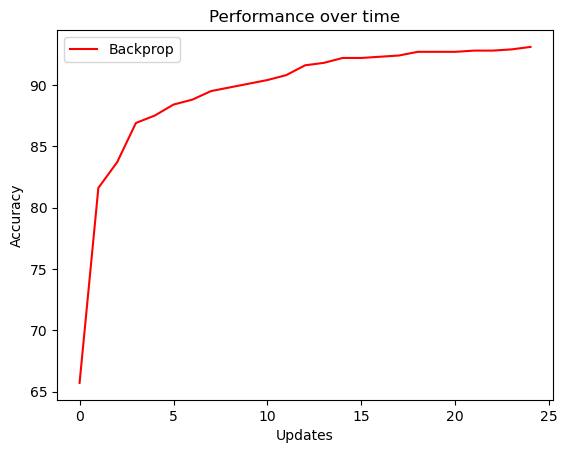

In [17]:
# accuracy_online = accuracy_online[::batchsize]
#plt.plot(losses_feedback, label="Feedback Alignment", color='g')
plt.plot(accuracy_bp_normal, label="Backprop", color='r')
'''
plt.plot(accuracy_kolepoll, label="Kolen-Pollack", color='k')
# plt.plot(accuracy_node_perturb, label="Node Perturbation", color='c')
plt.plot(accuracy_online, label="Online Learning", color='gold')
plt.plot(accuracy_nonstat, label="Non-stationary Data", color='forestgreen')
'''
# plt.plot(accuracy_noisy_input, label="Noisy Input Data", color='dodgerblue')
plt.xlabel("Updates")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Performance over time")
plt.show()

In [45]:
# Online learning
net_bp_online = MLP.MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_bp_online, accuracy_bp_online, test_loss_bp_online, snr_bp_online, cosine_similarity_bp_online) = \
    net_bp_online.train_online(rng, train_images, train_labels, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=0.01, max_it=100000, conv_loss = 1.75, algorithm='backprop', noise=noise, \
                      report=report, report_rate=batchsize)

Training starting...
At iteration 1, the accuracy is 10.8
At iteration 129, the accuracy is 7.9
At iteration 257, the accuracy is 17.1
At iteration 385, the accuracy is 11.700000000000001
At iteration 513, the accuracy is 12.0
At iteration 641, the accuracy is 9.6
At iteration 769, the accuracy is 19.400000000000002
At iteration 897, the accuracy is 10.5
At iteration 1025, the accuracy is 16.5
At iteration 1153, the accuracy is 29.4
At iteration 1281, the accuracy is 10.0
At iteration 1409, the accuracy is 24.4
At iteration 1537, the accuracy is 38.2
At iteration 1665, the accuracy is 22.2
At iteration 1793, the accuracy is 30.5
At iteration 1921, the accuracy is 30.8
At iteration 2049, the accuracy is 43.2
At iteration 2177, the accuracy is 34.8
At iteration 2305, the accuracy is 14.499999999999998
At iteration 2433, the accuracy is 34.1
At iteration 2561, the accuracy is 27.0
At iteration 2689, the accuracy is 35.0
At iteration 2817, the accuracy is 41.0
At iteration 2945, the accura

In [50]:
print(
    np.asarray(losses_bp_online).shape, 
    np.asarray(accuracy_bp_online).shape, 
    np.asarray(test_loss_bp_online).shape, 
    np.asarray(snr_bp_online), 
    np.asarray(cosine_similarity_bp_online).shape
)
np.save('results/net_bp_online/losses_bp_normal.npy', np.asarray(losses_bp_online))
np.save('results/net_bp_online/accuracy_bp_normal.npy', np.asarray(accuracy_bp_online))
np.save('results/net_bp_online/test_loss_bp_normal.npy', np.asarray(test_loss_bp_online))
np.save('results/net_bp_online/snr_bp_normal.npy', np.asarray(snr_bp_online))
np.save('results/net_bp_online/cosine_similarity_bp_normal.npy', np.asarray(cosine_similarity_bp_normal))

(232,) (231,) (231,) 0.10301087401898926 (231, 2)


FileNotFoundError: [Errno 2] No such file or directory: 'results/net_bp_online/losses_bp_normal.npy'

In [49]:
# Noisy Input
# create a network and train it using backprop
netbackprop_noisy = MLP.MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_bp_noisy, accuracy_bp_noisy, test_loss_bp_noisy, snr_bp_noisy, cosine_similarity_bp_noisy) = \
    netbackprop_noisy.train(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      noise_type='gauss',report=report, report_rate=rep_rate)

Training starting...


MemoryError: Unable to allocate 2.92 GiB for an array with shape (1000, 500, 785) and data type float64

In [ ]:
losses_bp_noisy.shape, accuracy_bp_noisy.shape, test_loss_bp_noisy.shape, snr_bp_noisy, cosine_similarity_bp_noisy.shape
np.save('results/netbackprop/losses_bp_normal.npy', losses_bp_noisy)
np.save('results/netbackprop/accuracy_bp_normal.npy', accuracy_bp_noisy)
np.save('results/netbackprop/test_loss_bp_normal.npy', test_loss_bp_noisy)
np.save('results/netbackprop/snr_bp_normal.npy', snr_bp_noisy)
np.save('results/netbackprop/cosine_similarity_bp_normal.npy', cosine_similarity_bp_noisy)

In [ ]:
# Non-Stationary Data
net_bp_nonstat = MLP.MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_bp_nonstat, accuracy_bp_nonstat, test_loss_bp_nonstat, snr_bp_nonstat, cosine_similarity_bp_nonstat) = \
    net_bp_nonstat.train_nonstat_data(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=1)

## FFA

In [8]:
# Normal learning
# create a network and train it using ffa
# netffa = MLP(rng_bp2, numhidden, sigma=initweight, activation=activation)
# (losses_ffa_normal, accuracy_ffa_normal, test_loss_ffa_normal, snr_ffa_normal, cosine_similarity_ffa_normal) = \
#     netffa.train(rng_bp2, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
#                       learning_rate=learnrate, batch_size=batchsize, algorithm='ffa', noise=noise, \
#                       report=report, report_rate=rep_rate)
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
netffa = net_ff_model.net_FF_model(rng)
(losses_ffa_normal, accuracy_ffa_normal, test_loss_ffa_normal) = netffa.train_over(
    train_images, train_labels, 
    test_images, test_labels,
    epochs=numepochs, model='ff_com', return_loss='cross_entropy'
)

seed: 42
device: cpu
input:
  path: datasets
  batch_size: 128
model:
  peer_normalization: 0.03
  momentum: 0.9
  hidden_dim: 500
  num_layers: 2
training:
  epochs: 100
  learning_rate: 0.001
  weight_decay: 0
  momentum: 0
  downstream_learning_rate: 0.001
  downstream_weight_decay: 0
  val_idx: 0
  final_test: true

FF_model(
  (model): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=500, bias=True)
  )
  (ff_loss): BCEWithLogitsLoss()
  (linear_classifier): Sequential(
    (0): Linear(in_features=500, out_features=10, bias=False)
  )
  (classification_loss): CrossEntropyLoss()
) 

...completed  0  epochs of training. 

            Current innate loss:  58.63556840358636, 

            Current training cross_entropy loss:  1.7526681716625507, 

            Current testing cross_entropy loss:  1.2275530099868774, 
   
            Current testing accuracy:  0.7907 
         
            
...completed  1  epochs o

KeyboardInterrupt: 

In [38]:
losses_ffa_normal.shape, accuracy_ffa_normal.shape, test_loss_ffa_normal.shape
np.save('results/netffa/losses_ffa_normal.npy', np.asarray(losses_ffa_normal))

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
netffa_online = net_ff_model.net_FF_model(rng)
(losses_ffa_online, accuracy_ffa_online, test_loss_ffa_online) = netffa_online.train_online(
    train_images, train_labels, 
    test_images[:, indices], test_labels[:, indices],
    max_it=25000, conv_loss=0.1, 
    report_rate=100, lr=0.01,
    model='ff_com', return_loss='cross_entropy'
)

In [ ]:
losses_ffa_online.shape, accuracy_ffa_online.shape, test_loss_ffa_online.shape

In [ ]:
# create a network and train it using ffa
# net_ffa_noisy = MLP(rng_bp2, numhidden, sigma=initweight, activation=activation)
# (losses_ffa_noisy, accuracy_ffa_noisy, test_loss_ffa_noisy, snr_ffa_noisy, cosine_similarity_ffa_noisy) = \
#     net_ffa_noisy.train(rng_bp2, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
#                       learning_rate=learnrate, batch_size=batchsize, algorithm='ffa', noise=noise, \
#                       noise_type='gauss',report=report, report_rate=rep_rate)
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
net_ffa_noisy = net_ff_model.net_FF_model(rng)
(losses_ffa_noisy, accuracy_ffa_noisy, test_loss_ffa_noisy) = net_ffa_noisy.train_nonstationary(
    train_images, train_labels, 
    test_images[:, indices], test_labels[:, indices],
    epochs=numepochs, model='ff_com', return_loss='cross_entropy'
)

In [ ]:
# Non-Stationary Data
# net_ffa_nonstat = MLP(rng_bp2, numhidden, sigma=initweight, activation=activation)
# (losses_ffa_nonstat, accuracy_ffa_nonstat, test_loss_ffa_nonstat, snr_ffa_nonstat, cosine_similarity_ffa_nonstat) = \
#     net_ffa_nonstat.train_nonstat_data(rng_bp2, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
#                       learning_rate=learnrate, batch_size=batchsize, algorithm='ffa', noise=noise, \
#                       report=report, report_rate=1)
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
net_ffa_nonstat = net_ff_model.net_FF_model(rng)
(losses_ffa_nonstat, accuracy_ffa_nonstat, test_loss_ffa_nonstat) = net_ffa_nonstat.train_noisydata(
    train_images, train_labels, 
    test_images[:, indices], test_labels[:, indices],
    epochs=numepochs, model='ff_com', return_loss='cross_entropy'
)

## Node Perturbation

In [3]:
# Test
filenames= ["losses_node_perturb", "accuracy_node_perturb", "test_losses_node_perturb", "snr_node_perturb", "cosine_similarity_node_perturb"]

data = []

for i, name in enumerate(filenames):
  data.append(np.fromfile(f"data/node_perturb/test/{filenames[i]}.csv", dtype=float, sep=","))

losses_node_perturb_test = data[0]
accuracy_node_perturb_test = data[1]
test_losses_node_perturb_test = data[2]
snr_node_perturb_test = data[3]
cosine_similarity_node_perturb_test = data[4]

In [ ]:
# Normal Learning
# create a network and train it using node perturbation
# with contextlib.redirect_stdout(io.StringIO()):
#     netnodeperturb = NodePerturbMLP(rng_bp2, numhidden, num_inputs = 784, sigma=initweight, activation=activation)
#     (losses_np_normal, accuracy_np_normal, test_loss_np_normal, snr_np_normal, cosine_similarity_np_normal) = \
#         netnodeperturb.train(rng_bp2, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
#                              learning_rate=learnrate, batch_size=batchsize, algorithm='node_perturb', noise=noise, report=report, report_rate=rep_rate)

# to load the files again, in the main doc:
filenames= ["losses_node_perturb", "accuracy_node_perturb", "test_losses_node_perturb", "snr_node_perturb", "cosine_similarity_node_perturb"]

data = []

for i, name in enumerate(filenames):
  data.append(np.fromfile(f"data/node_perturb/normal/{filenames[i]}.csv", dtype=float, sep=","))

losses_node_perturb_normal = data[0]
accuracy_node_perturb_normal = data[1]
test_losses_node_perturb_normal = data[2]
snr_node_perturb_normal = data[3]
cosine_similarity_node_perturb_normal = data[4]

In [ ]:
# Online Learning
# with contextlib.redirect_stdout(io.StringIO()):
#     netnodeperturb_online = NodePerturbMLP(rng_bp2, numhidden, num_inputs = 784, sigma=initweight, activation=activation)
#     (losses_np_online, accuracy_np_online, test_loss_np_online, snr_np_online, cosine_similarity_np_online) = \
#         netnodeperturb_online.train_online(rng_bp2, train_images, train_labels, test_images[:, indices], test_labels[:, indices], \
#                       learning_rate=0.01, max_it=numupdates*batchsize, conv_loss = 1e-4, algorithm='node_perturb', noise=noise, \
#                       report=report, report_rate=batchsize)

# to load the files again, in the main doc:
filenames= ["losses_node_perturb", "accuracy_node_perturb", "test_losses_node_perturb", "snr_node_perturb", "cosine_similarity_node_perturb"]

data = []

for i, name in enumerate(filenames):
  data.append(np.fromfile(f"data/node_perturb/online/{filenames[i]}.csv", dtype=float, sep=","))

losses_node_perturb_online = data[0]
accuracy_node_perturb_online = data[1]
test_losses_node_perturb_online = data[2]
snr_node_perturb_online = data[3]
cosine_similarity_node_perturb_online = data[4]

In [ ]:
# Noisy Input
# with contextlib.redirect_stdout(io.StringIO()):
#     nodeperturb_noisy = NodePerturbMLP(rng_bp2, numhidden, num_inputs = 784, sigma=initweight, activation=activation)
#     (losses_np_noisy, accuracy_np_noisy, test_loss_np_noisy, snr_np_noisy, cosine_similarity_np_noisy) = \
#         nodeperturb_noisy.train(rng_bp2, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
#                         learning_rate=learnrate, batch_size=batchsize, algorithm='node_perturb', noise=noise, \
#                         noise_type='gauss',report=report, report_rate=rep_rate)

# to load the files again, in the main doc:
filenames= ["losses_node_perturb", "accuracy_node_perturb", "test_losses_node_perturb", "snr_node_perturb", "cosine_similarity_node_perturb"]

data = []

for i, name in enumerate(filenames):
  data.append(np.fromfile(f"data/node_perturb/noisy/{filenames[i]}.csv", dtype=float, sep=","))

losses_node_perturb_noisy = data[0]
accuracy_node_perturb_noisy = data[1]
test_losses_node_perturb_noisy = data[2]
snr_node_perturb_noisy = data[3]
cosine_similarity_node_perturb_noisy = data[4]

In [ ]:
# Non-Stationary Data
# with contextlib.redirect_stdout(io.StringIO()):
#     nodeperturb_nonstat = NodePerturbMLP(rng_bp2, numhidden, num_inputs = 784, sigma=initweight, activation=activation)
#     (losses_np_nonstat, accuracy_np_nonstat, test_loss_np_nonstat, snr_np_nonstat, cosine_similarity_np_nonstat) = \
#         nodeperturb_nonstat.train_nonstat_data(rng_bp2, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
#                         learning_rate=learnrate, batch_size=batchsize, algorithm='node_perturb', noise=noise, \
#                         report=report, report_rate=1)

# to load the files again, in the main doc:
filenames= ["losses_node_perturb", "accuracy_node_perturb", "test_losses_node_perturb", "snr_node_perturb", "cosine_similarity_node_perturb"]

data = []

for i, name in enumerate(filenames):
  data.append(np.fromfile(f"data/node_perturb/non-stat/{filenames[i]}.csv", dtype=float, sep=","))

losses_node_perturb_non_stat = data[0]
accuracy_node_perturb_non_stat = data[1]
test_losses_node_perturb_non_stat = data[2]
snr_node_perturb_non_stat = data[3]
cosine_similarity_node_perturb_non_stat = data[4]

## Kolen-Pollack

In [ ]:
# Normal Learning
netkolepoll = KolenPollackMLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_kp_normal, accuracy_kp_normal, test_loss_kp_normal, snr_kp_normal, cosine_similarity_kp_normal) = \
    netkolepoll.train(rng_kp, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='kolepoll', noise=noise, \
                      report=report, report_rate=rep_rate)

rng = np.random.default_rng(seed=seed)

In [ ]:
# Online Learning
net_kp_online = KolenPollackMLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_kp_online, accuracy_kp_online, test_loss_kp_online, snr_kp_online, cosine_similarity_kp_online) = \
    net_kp_online.train_online(rng, train_images, train_labels, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=0.01, max_it=numupdates*batchsize, conv_loss = 1e-1, algorithm='kolepoll', noise=noise, \
                      report=report, report_rate=batchsize)

In [ ]:
# Noisy Input
net_kp_noisy = KolenPollackMLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_kp_noisy, accuracy_kp_noisy, test_loss_kp_noisy, snr_kp_noisy, cosine_similarity_kp_noisy) = \
    net_kp_noisy.train(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='kolepoll', noise=noise, \
                      noise_type='gauss',report=report, report_rate=rep_rate)

In [ ]:
# Non-Stationary Data
net_kp_nonstat = KolenPollackMLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_kp_nonstat, accuracy_kp_nonstat, test_loss_kp_nonstat, snr_kp_nonstat, cosine_similarity_kp_nonstat) = \
    net_kp_nonstat.train_nonstat_data(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='kolepoll', noise=noise, \
                      report=report, report_rate=1)

## Final Plots

In [ ]:
# if run without node perturb and ffa
# FFA
snr_ffa_normal, cosine_similarity_ffa_normal = [0], [0]
snr_ffa_online, cosine_similarity_ffa_online = [0], [0]
snr_ffa_noisy, cosine_similarity_ffa_noisy = [0], [0]
snr_ffa_nonstat, cosine_similarity_ffa_nonstat = [0], [0]

# Node Perturb
losses_np_normal, accuracy_np_normal, test_loss_np_normal, snr_np_normal, cosine_similarity_np_normal = [0], [0], [0], [0], [0]
losses_np_online, accuracy_np_online, test_loss_np_online, snr_np_online, cosine_similarity_np_online = [0], [0], [0], [0], [0]
losses_np_noisy, accuracy_np_noisy, test_loss_np_noisy, snr_np_noisy, cosine_similarity_np_noisy = [0], [0], [0], [0], [0]
losses_np_nonstat, accuracy_np_nonstat, test_loss_np_nonstat, snr_np_nonstat, cosine_similarity_np_nonstat = [0], [0], [0], [0], [0]


In [ ]:
# create arrays
# normal 
tr_loss_normal = [losses_bp_normal, losses_ffa_normal, losses_np_normal, losses_kp_normal]
te_acc_normal = [accuracy_bp_normal, accuracy_ffa_normal, accuracy_np_normal, accuracy_kp_normal]
te_loss_normal = [test_loss_bp_normal, test_loss_ffa_normal, test_loss_np_normal, test_loss_kp_normal]
snr_normal = [snr_bp_normal, snr_ffa_normal, snr_np_normal, snr_kp_normal]
cosine_similarity_normal = [cosine_similarity_bp_normal, cosine_similarity_ffa_normal, cosine_similarity_np_normal, cosine_similarity_kp_normal]

# online
# Calculate the moving average
window_size = 100
losses_bp_online_mean = uniform_filter1d(losses_bp_online, size=window_size)
losses_ffa_online_mean = uniform_filter1d(losses_ffa_online, size=window_size)
losses_np_online_mean = uniform_filter1d(losses_np_online, size=window_size)
losses_kp_online_mean = uniform_filter1d(losses_kp_online, size=window_size)
tr_loss_online_mean = [losses_bp_online_mean, losses_ffa_online_mean, losses_np_online_mean, losses_kp_online_mean]

tr_loss_online = [losses_bp_online, losses_ffa_online, losses_np_online, losses_kp_online]
te_acc_online = [accuracy_bp_online, accuracy_ffa_online, accuracy_np_online, accuracy_kp_online]
te_loss_online = [test_loss_bp_online, test_loss_ffa_online, test_loss_np_online, test_loss_kp_online]
snr_online = [snr_bp_online, snr_ffa_online, snr_np_online, snr_kp_online]
cosine_similarity_online = [cosine_similarity_bp_online, cosine_similarity_ffa_online, cosine_similarity_np_online, cosine_similarity_kp_online]

# noisy
tr_loss_noisy = [losses_bp_noisy, losses_ffa_noisy, losses_np_noisy, losses_kp_noisy]
te_acc_noisy = [accuracy_bp_noisy, accuracy_ffa_noisy, accuracy_np_noisy, accuracy_kp_noisy]
te_loss_noisy = [test_loss_bp_noisy, test_loss_ffa_noisy, test_loss_np_noisy, test_loss_kp_noisy]
snr_noisy = [snr_bp_noisy, snr_ffa_noisy, snr_np_noisy, snr_kp_noisy]
cosine_similarity_noisy = [cosine_similarity_bp_noisy, cosine_similarity_ffa_noisy, cosine_similarity_np_noisy, cosine_similarity_kp_noisy]

# nonstat
tr_loss_nonstat = [losses_bp_nonstat, losses_ffa_nonstat, losses_np_nonstat, losses_kp_nonstat]
te_acc_nonstat = [accuracy_bp_nonstat, accuracy_ffa_nonstat, accuracy_np_nonstat, accuracy_kp_nonstat]
te_loss_nonstat = [test_loss_bp_nonstat, test_loss_ffa_nonstat, test_loss_np_nonstat, test_loss_kp_nonstat]
snr_nonstat = [snr_bp_nonstat, snr_ffa_nonstat, snr_np_nonstat, snr_kp_nonstat]
cosine_similarity_nonstat = [cosine_similarity_bp_nonstat, cosine_similarity_ffa_nonstat, cosine_similarity_np_nonstat, cosine_similarity_kp_nonstat]

# algorithms
# algos = ['normal', 'online', 'noisy', 'nonstat']
algos = ['normal', 'noisy', 'nonstat']

In [ ]:
# plotting
for i, algo in enumerate(algos):
    if algo == 'normal':
        tr_loss, te_acc, te_loss, snr, cos_sim = tr_loss_normal, te_acc_normal, te_loss_normal, snr_normal, cosine_similarity_normal
    # elif algo == 'online':
    #     tr_loss, te_acc, te_loss, snr, cos_sim = tr_loss_online, te_acc_online, te_loss_online, snr_online, cosine_similarity_online
    elif algo == 'noisy':
        tr_loss, te_acc, te_loss, snr, cos_sim = tr_loss_noisy, te_acc_noisy, te_loss_noisy, snr_noisy, cosine_similarity_noisy
    elif algo == 'nonstat':
        tr_loss, te_acc, te_loss, snr, cos_sim = tr_loss_nonstat, te_acc_nonstat, te_loss_nonstat, snr_nonstat, cosine_similarity_nonstat
        
    # plot
    plt.figure(figsize=(30, 5))
    plt.subplot(151)

    plt.plot(tr_loss[0], label="Backprop", color='r')
    plt.plot(tr_loss[1], label="FFA", color='gold')
    plt.plot(tr_loss[2], label="Node Perturbation", color='c')
    plt.plot(tr_loss[3], label="Kolen-Pollack", color='k')
    
    plt.xlabel("Updates (every batch)")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Training loss")

    plt.subplot(152)
    plt.plot(te_acc[0], label="Backprop", color='r')
    plt.plot(te_acc[1], label="FFA", color='gold')
    plt.plot(te_acc[2], label="Node Perturbation", color='c')
    plt.plot(te_acc[3], label="Kolen-Pollack", color='k')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Performance over time")

    plt.subplot(153)
    plt.plot(te_loss[0], label="Backprop", color='r')
    plt.plot(te_loss[1], label="FFA", color='gold')
    plt.plot(te_loss[2], label="Node Perturbation", color='c')
    plt.plot(te_loss[3], label="Kolen-Pollack", color='k')
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Test loss")

    plt.subplot(154)
    with plt.xkcd():
            x = [0, 1, 2, 3]
            snr_vals = [snr[1], snr[2], snr[3], snr[0]]
            colors = ['gold', 'c', 'k', 'r']
            labels = ['FFA', 'Node Perturbation', 'Kolen Pollack', 'Backprop']
            plt.bar(x, snr_vals, color=colors, tick_label=labels)
            plt.xticks(rotation=90)
            plt.ylabel('SNR')
            plt.xlabel('Algorithm')
            plt.title('Gradient SNR')

    plt.subplot(155)
    with plt.xkcd():
        plt.plot(cos_sim[0], label="Backprop", color='r')
        plt.plot(cos_sim[1], label="FFA", color='gold')
        plt.plot(cos_sim[2], label="Node Perturbation", color='c')
        plt.plot(cos_sim[3], label="Kolen-Pollack", color='k')
        plt.xlabel("Epochs")
        plt.ylabel("Cosine Sim")
        plt.legend()
        plt.title("Cosine Similarity to Backprop")
plt.show()

In [ ]:
# Online Learning separately becuase of different lenghts and additional smoothing operation
# plot
plt.figure(figsize=(30, 5))
plt.subplot(151)

plt.plot(tr_loss_online[0], label="Backprop", color='r')
plt.plot(tr_loss_online[1], label="FFA", color='gold')
plt.plot(tr_loss_online[2], label="Node Perturbation", color='c')
plt.plot(tr_loss_online[3], label="Kolen-Pollack", color='k')

plt.xlabel("Updates (every batch)")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")

plt.subplot(152)
plt.plot(te_acc_online[0], label="Backprop", color='r')
plt.plot(te_acc_online[1], label="FFA", color='gold')
plt.plot(te_acc_online[2], label="Node Perturbation", color='c')
plt.plot(te_acc_online[3], label="Kolen-Pollack", color='k')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Performance over time")

plt.subplot(153)
plt.plot(te_loss_online[0], label="Backprop", color='r')
plt.plot(te_loss_online[1], label="FFA", color='gold')
plt.plot(te_loss_online[2], label="Node Perturbation", color='c')
plt.plot(te_loss_online[3], label="Kolen-Pollack", color='k')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.title("Test loss")

plt.subplot(154)
with plt.xkcd():
        x = [0, 1, 2, 3]
        snr_vals = [snr_online[1], snr_online[2], snr_online[3], snr_online[0]]
        colors = ['gold', 'c', 'k', 'r']
        labels = ['FFA', 'Node Perturbation', 'Kolen Pollack', 'Backprop']
        plt.bar(x, snr_vals, color=colors, tick_label=labels)
        plt.xticks(rotation=90)
        plt.ylabel('SNR')
        plt.xlabel('Algorithm')
        plt.title('Gradient SNR')

plt.subplot(155)
with plt.xkcd():
    plt.plot(cosine_similarity_online[0], label="Backprop", color='r')
    plt.plot(cosine_similarity_online[1], label="FFA", color='gold')
    plt.plot(cosine_similarity_online[2], label="Node Perturbation", color='c')
    plt.plot(cosine_similarity_online[3], label="Kolen-Pollack", color='k')
    plt.xlabel("Epochs")
    plt.ylabel("Cosine Sim")
    plt.legend()
    plt.title("Cosine Similarity to Backprop")

plt.show()